In [33]:
%load_ext autoreload
%autoreload 2
    
from d3pm_sc.ct_sched_cond import ScheduleCondition
from d3pm_sc.masking_diffusion import MaskingDiffusion
from d3pm_sc.d3pm_classic import D3PM_classic
from d3pm_sc.unet import UNet, SimpleUNet
from d3pm_sc.dit import DiT_Llama
from d3pm_sc import utils
from d3pm_sc.trainer import DiffusionTrainer, get_gif


import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import make_grid
from tqdm import tqdm

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
N = 128  # number of classes for discretized state per pixel
n_channel = 3
gamma = 0

s_dim = 4
conditional = True
forward_kwargs = {"type":"gaussian",
                  "normalized": False,
                  "bandwidth":1 / 7}

batch_size = 16
device = "cuda"
n_epoch = 14

# Schedule conditioning
# x0_model = DiT_Llama(n_channel, N, 50, True, s_dim=s_dim, dim=1024)
x0_model = SimpleUNet(n_channel, N, 500, True, s_dim=4)
model = ScheduleCondition(x0_model, num_classes=N, hybrid_loss_coeff=0.01, gamma=gamma,
                          forward_kwargs=forward_kwargs, logistic_pars=True)
gen_trans_step = 200

# # Masking
# x0_model = SimpleUNet(n_channel, N+1, 50, False, s_dim=4)
# model = MaskingDiffusion(x0_model, num_classes=N, hybrid_loss_coeff=0.01).cuda()
# gen_trans_step = 50

if device == 'cuda':
    model = model.cuda()
print(f"Total Param Count: {sum([p.numel() for p in model.x0_model.parameters()])}")

# Load data
dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
)
def collate_fn(batch):
    x, cond = zip(*batch)
    x = torch.stack(x)
    cond = torch.tensor(cond)
    cond = (cond * conditional)
    x = (x * (N - 1)).round().long().clamp(0, N - 1)
    return x, cond
train_size = int(len(dataset) * 0.9)
dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=16, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16, collate_fn=collate_fn)


/home/alan_a/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'x0_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['x0_model'])`.


Total Param Count: 1933712
Files already downloaded and verified


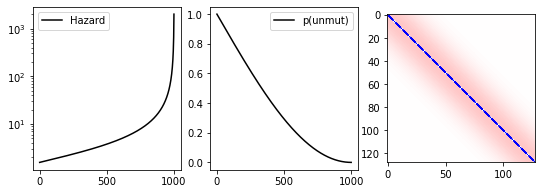

In [28]:
steps = torch.arange(1000 + 1, dtype=torch.float64) / 1000

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].semilogy(model.beta(steps), label="Hazard", color='black')
ax[0].legend()

alpha_bar = torch.exp(model.log_alpha(steps))
ax[1].plot(alpha_bar, label="p(unmut)", color='black')
ax[1].legend()

L = utils.get_inf_gens(forward_kwargs, N)
ax[2].imshow(L, vmin=-0.1, vmax=0.1, cmap='bwr')

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project="debugging")
lightning_model = model

trainer = Trainer(max_epochs=10, accelerator='auto', devices='auto', logger=wandb_logger)
trainer.fit(lightning_model, dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name     | Type       | Params | Mode
-----------------------------------------------
0 | x0_model | SimpleUNet | 1.9 M  | eval
-----------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.735     Total estimated model params size (MB)
0         Modules in train mode
27        Modules in eval mode


Sanity Checking: |                                                                                         | 0…

44000iteration [00:27, 1610.71iteration/s]                                                                                       


Training: |                                                                                                | 0…